In [3]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [4]:
# datasets: 'digits', 'fashion'
dataset = 'digits'

In [5]:
if dataset == 'digits':
    data = torchvision.datasets.MNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.MNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "0",
        1: "1",
        2: "2",
        3: "3",
        4: "4",
        5: "5",
        6: "6",
        7: "7",
        8: "8",
        9: "9",
    }
elif dataset == 'fashion':
    data = torchvision.datasets.FashionMNIST(
        root='data',
        train=True,
        download=True,
        transform=ToTensor()
    )

    test_data = torchvision.datasets.FashionMNIST(
        root='data',
        train=False,
        download=True,
        transform=ToTensor()
    )
    labels_map = {
        0: "T-Shirt",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }

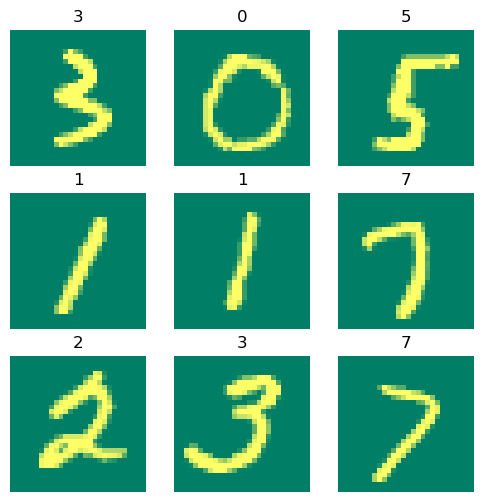

In [6]:
figure = plt.figure(figsize=(6,6))
cols, rows = 3, 3
for i in range(1, cols*rows + 1):
    sample_index = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_index]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.title(labels_map[label])
    plt.imshow(img.squeeze(), cmap="summer")
plt.show()


In [7]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [37]:
class VarAutoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28+1, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 40),
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2+1, 20),
            nn.ReLU(),
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
        self.linear1 = nn.Linear(20, 2)
        self.linear2 = nn.Linear(20, 2)
        self.G = torch.distributions.Normal(0, 1)

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        return mu + std*self.G.sample(mu.shape)

    def sample(self, digit=None):
        " Generate a new digit, optional: digit (int)"
        if digit is None:
            digit = numpy.random.randint(0, 10)
        y = torch.tensor(digit)
        z = torch.randn(2)
        z_cond = torch.cat((z, y))
        return self.decoder(z_cond), digit

    def forward(self, x, y):
        x_cond = torch.cat((x,y), dim=1)
        x = self.encoder(x_cond)
        mu = self.linear1(x)
        logvar = self.linear2(x)
        z = self.reparametrize(mu, logvar)
        z_cond = torch.cat((z, y), dim=1)
        output = self.decoder(z_cond)
        return output, mu, logvar

    def generate_digits(self):
        for j in range(10):
            fig = plt.figure(figsize=(14,10))
            with torch.no_grad():
                for i in range(10):
                    x, _ = self.sample(j)
                    ax = fig.add_subplot(1,10,i+1)
                    ax.imshow(x.squeeze().reshape(28,28), cmap='pink')
            plt.title(j)
            plt.show()

VAE = VarAutoencoder()

In [38]:
learning_rate = 1e-4
batch_size = 32

In [39]:
loss_1 = nn.MSELoss()
def loss_2(mu, logvar):
    return torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - torch.exp(logvar), dim = 1), dim = 0).sum()

In [40]:
#optimizer = torch.optim.SGD(ae.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(VAE.parameters(),
                             lr = learning_rate,
                             weight_decay = 1e-8)
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True)

Epoch  0
loss1 tensor(0.2321) loss2 tensor(0.0380)
[16  1  6 27]


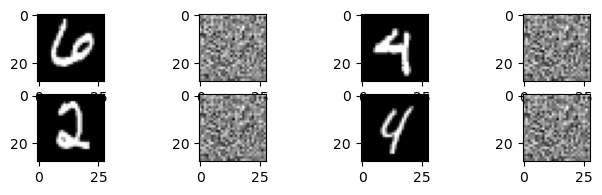

2.321171998977661
Epoch  1
loss1 tensor(0.0561) loss2 tensor(2.4305)
[25  5  9  1]


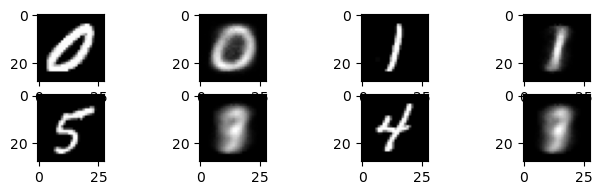

0.573036253452301
Epoch  2
loss1 tensor(0.0559) loss2 tensor(3.3901)
[15  3 25 22]


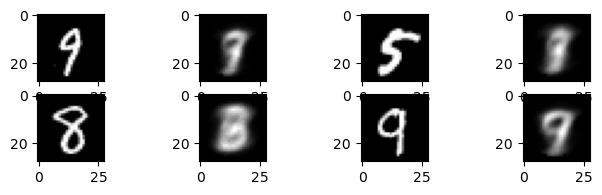

0.5762017369270325
Epoch  3
loss1 tensor(0.0554) loss2 tensor(3.8334)
[16 30 11  1]


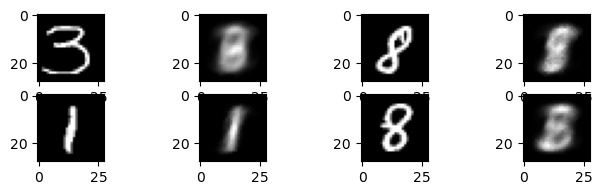

0.5728031396865845
Epoch  4
loss1 tensor(0.0501) loss2 tensor(3.6253)
[ 3  3 19 21]


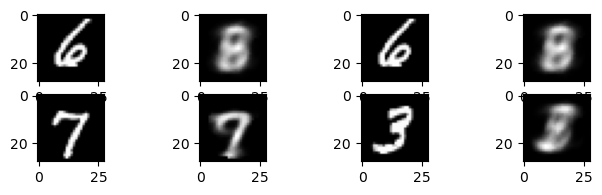

0.5190242528915405
Epoch  5
loss1 tensor(0.0504) loss2 tensor(3.5901)
[ 0 14 17 29]


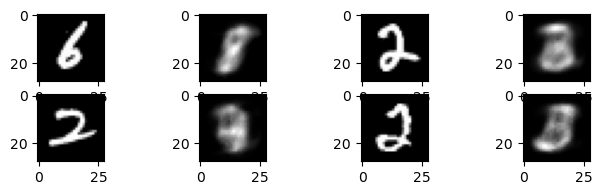

0.5217694044113159
Epoch  6
loss1 tensor(0.0436) loss2 tensor(4.1640)
[21 18  0 12]


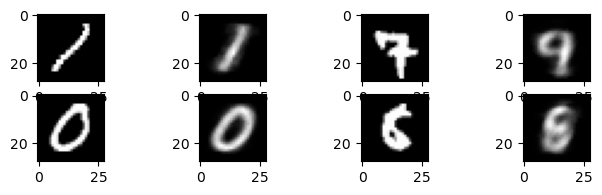

0.45684146881103516
Epoch  7
loss1 tensor(0.0459) loss2 tensor(3.9499)
[13 28  5  2]


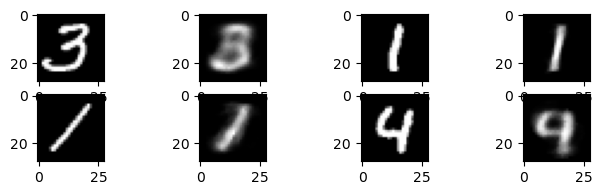

0.47876250743865967
Epoch  8
loss1 tensor(0.0513) loss2 tensor(3.8886)
[12  2 14 15]


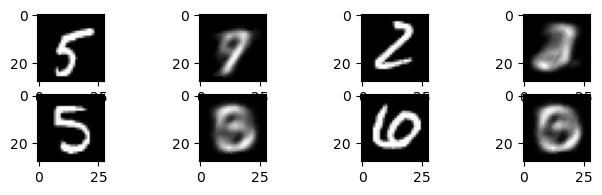

0.5320926904678345
Epoch  9
loss1 tensor(0.0392) loss2 tensor(4.0189)
[ 4 23  5 27]


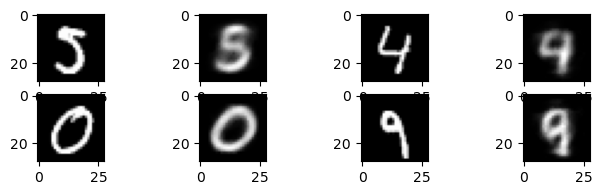

0.4118945896625519
Epoch  10
loss1 tensor(0.0512) loss2 tensor(4.2940)
[26 17 19  9]


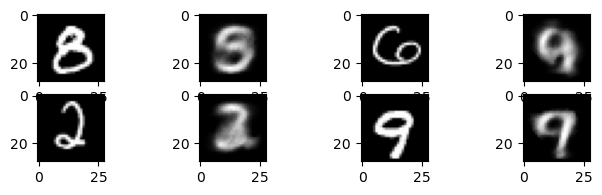

0.533753514289856
Epoch  11
loss1 tensor(0.0441) loss2 tensor(4.4321)
[18  1  8 18]


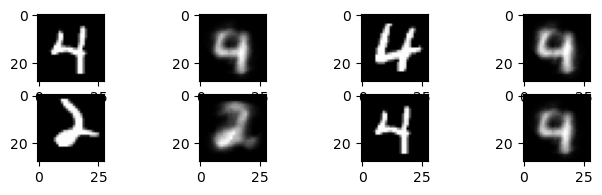

0.4627286195755005
Epoch  12
loss1 tensor(0.0448) loss2 tensor(4.3586)
[30 20  9 27]


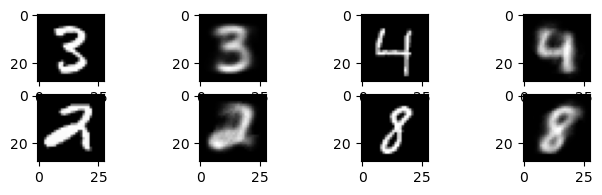

0.4695810377597809
Epoch  13
loss1 tensor(0.0438) loss2 tensor(4.7262)
[ 1 10 13  8]


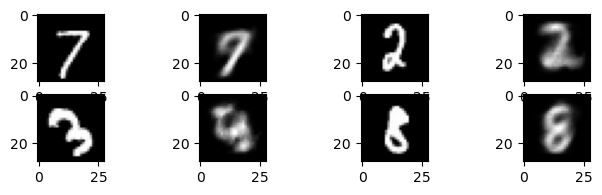

0.4617777466773987
Epoch  14
loss1 tensor(0.0374) loss2 tensor(4.5062)
[14 26  5  5]


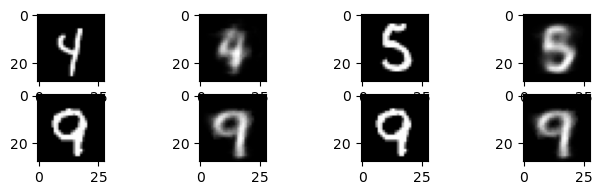

0.39671677350997925
Epoch  15
loss1 tensor(0.0443) loss2 tensor(4.5769)
[18  6 13 14]


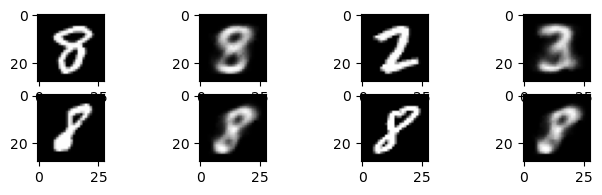

0.46568459272384644
Epoch  16
loss1 tensor(0.0388) loss2 tensor(4.7910)
[ 1  4  6 23]


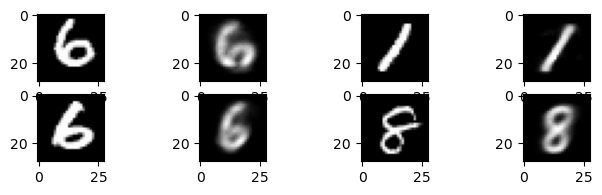

0.41219663619995117
Epoch  17
loss1 tensor(0.0432) loss2 tensor(4.6126)
[ 0 13 15  5]


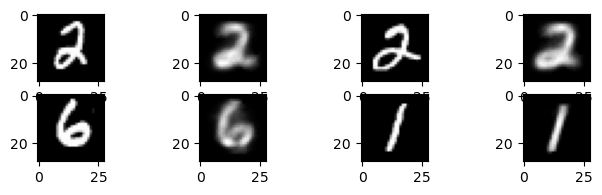

0.45523831248283386
Epoch  18
loss1 tensor(0.0396) loss2 tensor(4.8606)
[ 3 10  4 11]


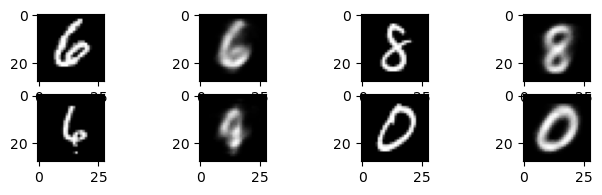

0.4200740158557892
Epoch  19
loss1 tensor(0.0398) loss2 tensor(4.7106)
[15  8 29 18]


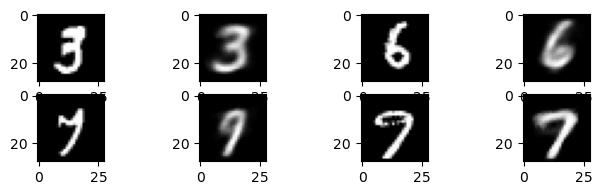

0.42202889919281006
Epoch  20
loss1 tensor(0.0390) loss2 tensor(4.7696)
[29 31 27  4]


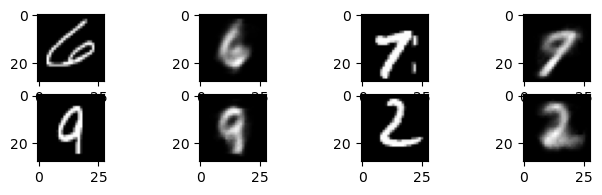

0.41406577825546265
Epoch  21
loss1 tensor(0.0393) loss2 tensor(5.0864)
[13 27 28  9]


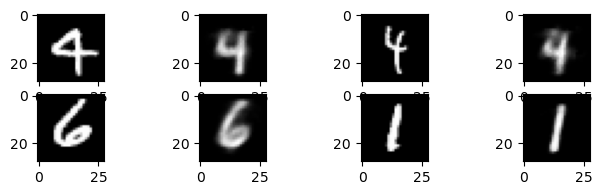

0.4180122911930084
Epoch  22
loss1 tensor(0.0416) loss2 tensor(4.8353)
[28 28 25 25]


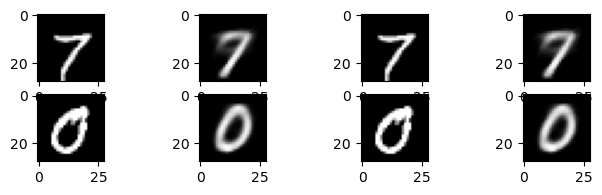

0.4399760663509369
Epoch  23
loss1 tensor(0.0420) loss2 tensor(4.8939)
[ 9  8 13 26]


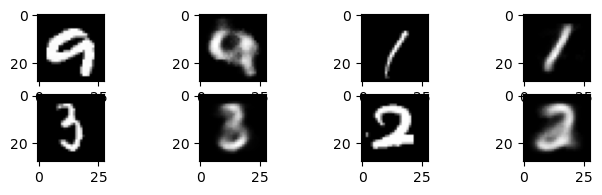

0.4448491036891937
Epoch  24
loss1 tensor(0.0337) loss2 tensor(4.9647)
[13  6 25 26]


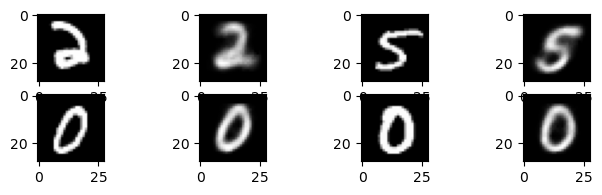

0.3617045283317566
Epoch  25
loss1 tensor(0.0383) loss2 tensor(4.8609)
[18 11  8 13]


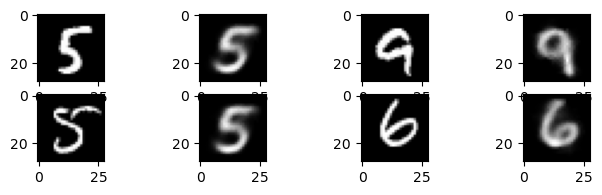

0.40770769119262695
Epoch  26
loss1 tensor(0.0400) loss2 tensor(5.1131)
[31 16  8  1]


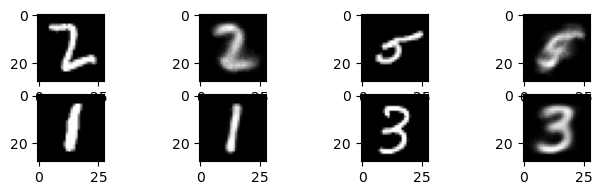

0.42600101232528687
Epoch  27
loss1 tensor(0.0393) loss2 tensor(4.9483)
[ 3 19 25 24]


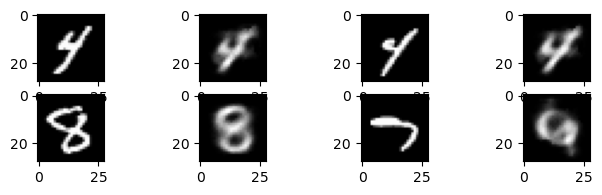

0.41808462142944336
Epoch  28
loss1 tensor(0.0343) loss2 tensor(4.9355)
[ 9 19  7 17]


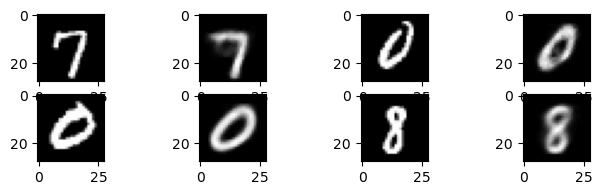

0.3679986596107483
Epoch  29
loss1 tensor(0.0359) loss2 tensor(5.1409)
[21 18 14 11]


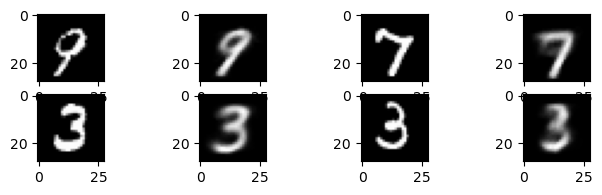

0.3851604461669922


In [41]:
# Training loop
epochs = 30
losses = []
beta1 = 10
beta2 = 0.005
for epoch in range(epochs):
    plot = True
    VAE.train()
    for (image, label) in data_loader:

        # Reshape image, label for input
        image = image.reshape(-1, 784)
        label = label.unsqueeze(1)
        # Feed through the network
        reconstruction, mu, logvar = VAE(image, label)
        # Calculate loss function
        loss = beta1*loss_1(reconstruction, image) + beta2*loss_2(mu, logvar)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if plot==True:
            fig = plt.figure(figsize=(8,4))
            print('Epoch ', epoch)
            with torch.no_grad():
                print('loss1', loss_1(reconstruction, image), 'loss2', loss_2(mu, logvar))
                recon_plot = reconstruction.reshape(-1, 28, 28)
                images_plot = image.reshape(-1, 28, 28)
                indices = numpy.random.choice(32, 4)
                print(indices)
                for i, ind in enumerate(indices):
                    ax1 = fig.add_subplot(4,4,2*i+1)
                    ax1.imshow(images_plot[ind], cmap='gray')
                    ax2 = fig.add_subplot(4,4,2*i+2)
                    ax2.imshow(recon_plot[ind], cmap='gray')
            
            plt.show()
            print(losses[-1])
            plot=False        

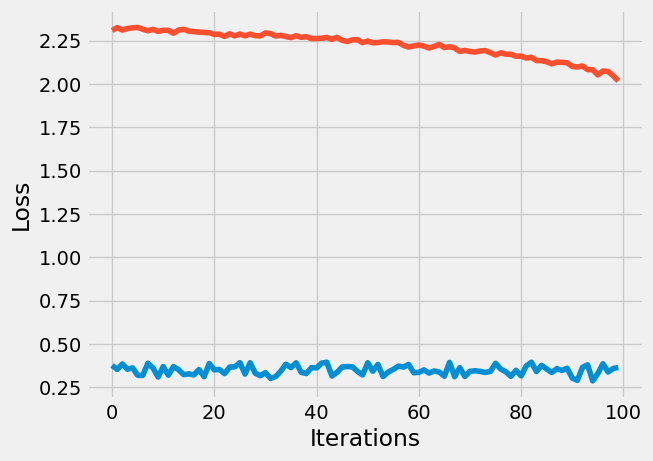

In [170]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])
plt.plot(losses[:100])

In [1]:
img, _ = VAE.sample(6)
plt.imshow(img.detach().reshape(28,28), cmap='pink')

NameError: name 'VAE' is not defined

In [27]:
VAE.generate_digits()

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

<Figure size 1400x1000 with 0 Axes>

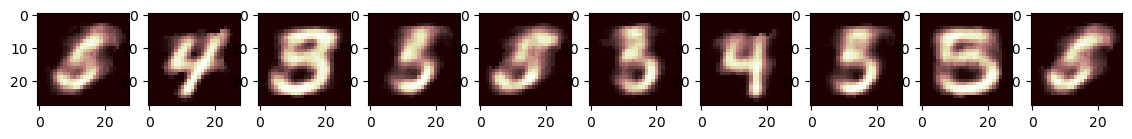

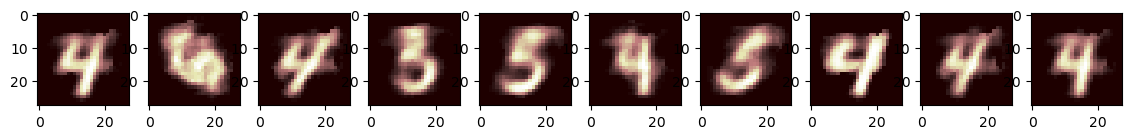

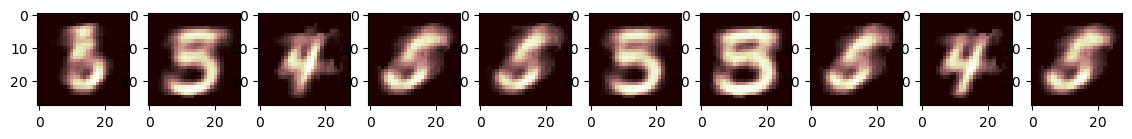

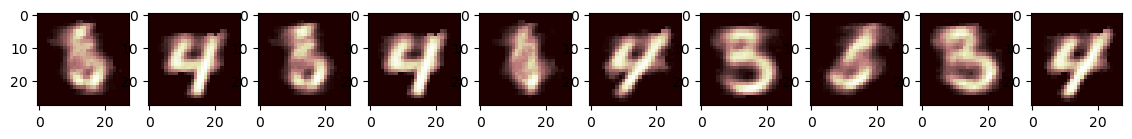

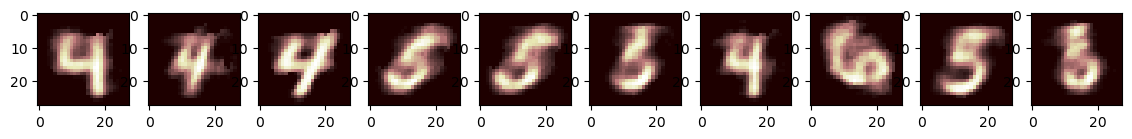

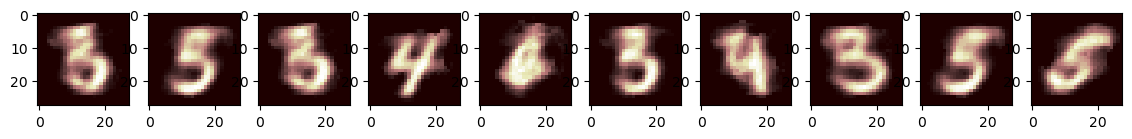

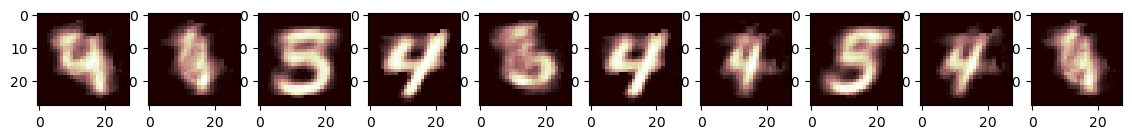

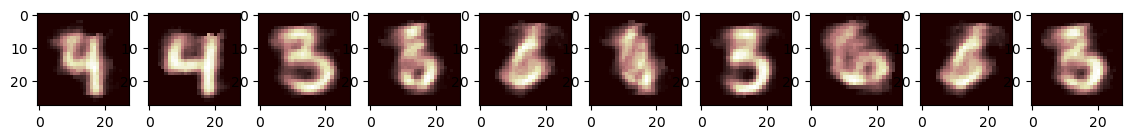

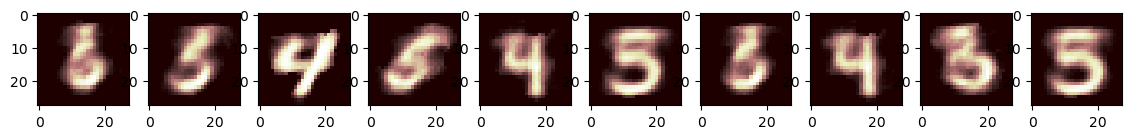

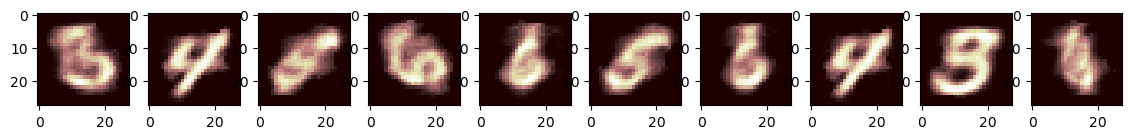

In [49]:
for j in range(10):
    fig = plt.figure(figsize=(14,10))
    with torch.no_grad():
        for i in range(10):
            z = torch.randn(2)
            y = torch.zeros(1)
            y[0] = 4
            z_cond = torch.cat((z,y))
            img = VAE.decoder(z_cond)
            ax = fig.add_subplot(1,10,i+1)
            ax.imshow(img.reshape(28,28), cmap='pink')
    plt.show()